# Neural Network Traning

In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from CONSTANTS import ML
import os
import glob

print('---------------------------------------------------------------------------')
print('TF: {}'.format(tf.__version__))
print('---------------------------------------------------------------------------')

########################################################################
# Change file path HERE
########################################################################
dataDir = os.path.join(os.getcwd(), 'data')
csvFiles = glob.glob(dataDir + '/*.csv')

---------------------------------------------------------------------------
TF: 2.3.0
---------------------------------------------------------------------------


# Compiling dataset features

Total number of features = 19

### Power Spectrum Bins

`1, 2, 3, 4, 10, 11, 22, 23, 43, 44, 45, 109, 110, 125, 126`

### MFCC Bins

`1, 10`

### Spectral Flatness

Spectral flatness value and delta spectral flatness

In [3]:
def extract_features(df):
    datasets = np.empty([df.shape[0], ML['NUMBER_OF_FEATURES']])

    for index, row in df.iterrows():
        sample = np.array([
            row['powerSpectrum_1'],
            row['powerSpectrum_2'],
            row['powerSpectrum_3'],
            row['powerSpectrum_4'],
            row['powerSpectrum_10'],
            row['powerSpectrum_11'],
            row['powerSpectrum_22'],
            row['powerSpectrum_23'],
            row['powerSpectrum_43'],
            row['powerSpectrum_44'],
            row['powerSpectrum_45'],
            row['powerSpectrum_109'],
            row['powerSpectrum_110'],
            row['powerSpectrum_125'],
            row['powerSpectrum_126'],
            row['mfcc_1'],
            row['mfcc_10'],
            row['spectralFlatness'],
            row['delta_spectralFlatness']
        ])
        datasets[index] = sample
    
    return datasets

# Preprocessing

- Create one hot for the three classes (Chloe, Beep, and Music)
- Feature standardization
- Create Tensor datasets and shuffle the order

In [4]:
def standardize(x, axes=[0], epsilon=1e-8):
    mean, variance = tf.nn.moments(x, axes=axes)
    x_normed = (x - mean) / tf.sqrt(variance + epsilon) # epsilon to avoid dividing by zero
    return x_normed


def preprocess(x, y):
    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.int64)
    return x, y


def preprocess_standardized(x, y):
    x = tf.cast(x, tf.float32)
    x_normed = standardize(x)
    y = tf.cast(y, tf.int64)
    return x_normed, y


def create_dataset(xs, ys, n_classes=ML['N_CLASSES']):
    ys = tf.one_hot(ys, depth=n_classes)
    return tf.data.Dataset.from_tensor_slices((xs, ys)).map(preprocess).shuffle(len(ys)).batch(128)


def create_dataset_standardized(xs, ys, n_classes=ML['N_CLASSES']):
    ys = tf.one_hot(ys, depth=n_classes)
    return tf.data.Dataset.from_tensor_slices((xs, ys)).map(preprocess_standardized).shuffle(len(ys)).batch(128)

# Process datasets
- Get data from csv files
- Extract the 19 required features
- Create, shuffle, and split datasets into training and validation (80/20 ratio)


In [5]:
dataframes = []
for file in csvFiles:
    df = pd.read_csv(file, sep=',', header=0)
    dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

extracted_datasets = extract_features(df)
classes = df['class'].to_numpy()

x_train, x_validation, y_train, y_validation = train_test_split(extracted_datasets,
                                                                classes,
                                                                test_size=0.2,
                                                                shuffle=True) 

print('Train dataset:\t\t' + str(x_train.shape[0]))
print('Validation dataset:\t' + str(y_validation.shape[0]))
print('------------------------------')
print('Total dataset:\t\t' + str(extracted_datasets.shape[0]))
print('------------------------------')

Train dataset:		3959
Validation dataset:	990
------------------------------
Total dataset:		4949
------------------------------


# Training
Using two hidden layers

**Input layer**<br/>
\# of input: 19 features

**First layer**<br/>
\# of neurons: 15<br/>
Activation fn: relu

**Second layer**
\# of neurons: 8<br/>
Activation fn: relu

**Output layer**<br/>
\# of output: 3<br/>
Activation fn: softmax

In [6]:
# Create dataset without standardized features, it did better
train_dataset = create_dataset(x_train, y_train)
validation_dataset = create_dataset(x_validation, y_validation)

model = keras.Sequential([
    keras.layers.Dense(units=15, activation='relu'),
    keras.layers.Dense(units=8, activation='relu'),
    keras.layers.Dense(units=ML['N_CLASSES'], activation='softmax')
])

model.compile(optimizer='adam', 
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_dataset.repeat(), 
    epochs=50, 
    steps_per_epoch=500,
    validation_data=validation_dataset.repeat(), 
    validation_steps=2
)

Epoch 1/50
500/500 [==============================] - 1s 3ms/step - loss: 0.7212 - accuracy: 0.8327 - val_loss: 0.7116 - val_accuracy: 0.8398
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 0.6727 - accuracy: 0.8833 - val_loss: 0.6675 - val_accuracy: 0.8828
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 0.6583 - accuracy: 0.8972 - val_loss: 0.6773 - val_accuracy: 0.8672
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 0.6517 - accuracy: 0.9015 - val_loss: 0.6445 - val_accuracy: 0.9102
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.6443 - accuracy: 0.9073 - val_loss: 0.6552 - val_accuracy: 0.8984
Epoch 6/50
500/500 [==============================] - 1s 3ms/step - loss: 0.6388 - accuracy: 0.9137 - val_loss: 0.6588 - val_accuracy: 0.8984
Epoch 7/50
500/500 [==============================] - 1s 3ms/step - loss: 0.6325 - accuracy: 0.9232 - val_loss: 0.6528 - val_accuracy: 0.8945
Epoch 

# Model Loss and Accuracy

The model currently approaches asymptotic loss at approximately 0.6 and training accuracy of 95%.

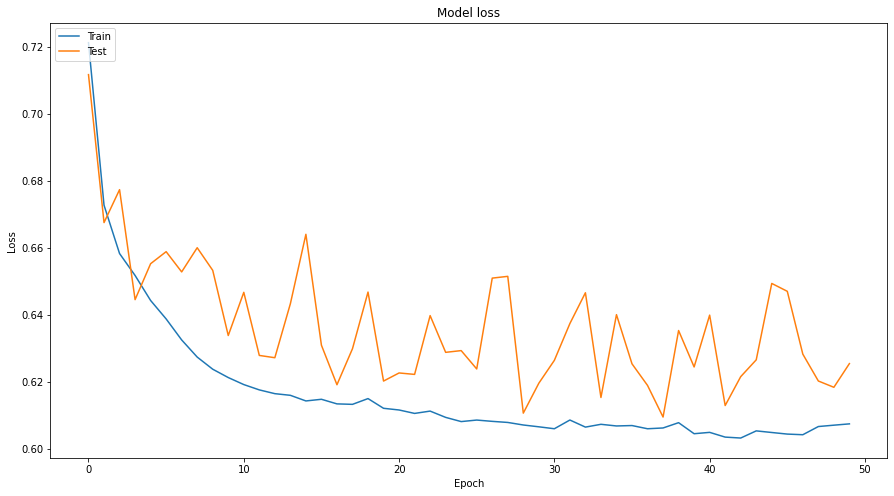

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(15,8))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

### Running on a validation dataset

In [8]:
from sklearn.metrics import accuracy_score

acc_val_csv = './data/validation-data/2020-08-02_17-21-22.csv'
acc_val_df = pd.read_csv(acc_val_csv, sep=',', header=0)

acc_val_extracted = extract_features(acc_val_df)
acc_val_class = acc_val_df['class'].to_numpy()

predictions = model.predict(acc_val_extracted)
predictions_class_number = list()

# Convert prediction from one hot [0, 1, 0] to number 2
for i in range(len(predictions)):
    predictions_class_number.append(np.argmax(predictions[i]))

accuracy = accuracy_score(predictions_class_number, acc_val_class)
print('Accuracy: ' + str(round(accuracy * 100.0, 2)) + '%')



Accuracy: 85.17%


### Save current model to `saved-models` directory

In [15]:
import pathlib
import tensorflowjs as tfjs

pathlib.Path("./saved-models/2020-08-13/python").mkdir(parents=True, exist_ok=True)
pathlib.Path("./saved-models/2020-08-13/js").mkdir(parents=True, exist_ok=True)
model.save('./saved-models/2020-08-13/python/model.h5')
tfjs.converters.save_keras_model(model, './saved-models/2020-08-13/js')

# Next step

Export the trained model and apply it to Chrome extension. Explore the use of AWS SageMaker to run the prediction. 